<a href="https://colab.research.google.com/github/xslittlemaggie/Deep-Learning-Machine-Learning-Projects/blob/master/LogisticRegression_RandomForest_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Kaggle project: Titanic classification</center></h1>

## Part 0: Import Needed packages

In [0]:
# Data analysis and wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import random as rnd
from collections import Counter


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt

## Part 1: Import data

In [0]:
# load data to colab from local manually
titanic = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
combine = [titanic, test]

#### 1. Which features are available in the dataset?

In [4]:
print(titanic.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [5]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Part 2: Features engineering

In [6]:
print(titanic.isnull().sum())
print("-" * 20)
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


For titanic (training) dataset, there is a total of 891 samples, while 177 (19/8%) missing values for age, 687 (77%) missing values for Cabin, and 2 missing values for Embarked. 

Next, I will repalce the missing values with reasonable approximations.

The similar feature engineer will be applied to test dataset

In [0]:
#print(titanic["Sex"].unique())
#titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
#titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

### 1. General descriptive analysis of the features

#### 1.1 What are the datatypes for various features?

Helping us during converting goal. 

1). Seven features are integer or floats. Six in case of test datasets. 

2). Five features are strings (object).

In [8]:
titanic.info()
print('_' * 40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

#### 1.2 What is the distribution of numerical feature values across the samples?

This helps us determine, among other early insights, how representative is the training dataset of the actual problem domain.

1). Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224)

2). Survived is a categorical feature with 0 or 1 values. 

3). Around 38% samples survived. (**code** : titanic.Survived.mean())

4). Most passengers (> 75%) did not travel with parents or children. (**code**: titanic.Parch.value_counts())

5). Nearly 30% of the passengers had siblings and/or spouse aboard. (**code**: titanic.SibSp.value_counts())

6). Fares varied significantly with few passengers (< 1%) paying as high as %521. (**code**: titanic.Fare.hist())

7). Few elderly passenger (< 1%) within age range 65 - 80. (**code**: titanic.Age.hist())

In [9]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### 1.3 What is the distribution of categorical features?

1). Names are unique across the dataset (count =  unique = 891)

2). Sex variable as two possible values with 65% male (top = male, freq = 577/count = 891)

3). Cabin values have several duplicates across samples. 

4). Embarked takes three possible values. S port used by most passengers (top = S)

5). Ticket feature has high ratio (22%) of duplicate values (unique = 681)

In [10]:
# Only get the descriptive information for the categorical features. 
titanic.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Hegarty, Miss. Hanora ""Nora""",male,347082,C23 C25 C27,S
freq,1,577,7,4,644


### 2. Features preprocessing

#### 2.1 Feature Correlating

We want to know how well does each feature coorelate with Survival. We want to do this early in our project and match these quick correlations with modelled correlations later in the project. 

#### 2.2 Feature correcting 

1). Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival. 

2). Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test datasets. 

3). PassengerId may be dropped from training dataset as it does not contribute to survival. 

4). Name feature is relative non-standard, may not contribute directly to survival, so maybe droppped. 

####2.3  Feature creating

1). We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board. 

2). We may want to engineer the Name feature to extract Title as a new feature. 

3). We may want to create new feature for Age bands. This turns a continuous numerical feature into an ordinal categorical feature. 

4). We may also want to create a Fare range feature if it helps our analysis. 

#### 2.4 Classifying

We may also add to our assumptions based on the problem description noted earlier. 

1). Women (sex = female) were more likely to have survived. 

2). Childre (Age < ?) were more likely to have survived. 

3). The upper-class passengers (Pclass = 1) were more likely to have survived. 

## Part 4: Analyzing by pivoting features

To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by pivoting features against each other. We can only do so at this stage for features which do not have an empty values. It alse makes sense doing so only for features which are categorical(Sex), ordinal (Pclass) or discrete(SibSp, Parch) type. 

1). Pclass - we observe significant correlation ( > 0.5) among Pclass =1 and Survived (classifying # 3). We decide to include this feature in our mode. 

2). Sex - we confirm the observation during problem definition that Sex = female had very high survial rate at 74% (classifying #1).

3). SibSp and parch - these features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features (creating # 1).

#### 1. Correlation between Pclass & Survived
Passengers from Class 1 are more likely to be survivied (63%).

In [11]:
titanic[['Pclass', 'Survived']].groupby(['Pclass'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


#### 2. Correlation between Sex & Survived
Females are more likely to be survivied (74%).

In [12]:
titanic[['Sex', 'Survived']].groupby(['Sex'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


#### 3. Correlation between SibSp & Survived
Passengers with 1 or 2 Siblings or Spouse are more likely to be survivied (53%, 46%).

In [13]:
titanic[['SibSp', 'Survived']].groupby(['SibSp'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


#### 4. Correlation between Parch & Survived
Passengers with 1, 2, or 3 Parents, children in total are more likely to be survivied (55%, 50%, 60%).

In [14]:
titanic[['Parch', 'Survived']].groupby(['Parch'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## Part 5: Analyzing by visualizing data

Now we can continue confirming some of our assumptions using visualizations for analyzing the data. 

### 1 Correlating numerical features,  Age & survival

Let us start by understanding correlations between numerical features and our solution goal (Survived).

A histogram chart is useful for analyzing continuous numerical variables Age where banding or ranges will help identify useful patterns. The histogram can inddicate distribution of samples using automatically defined bins or equally ranged bands. This helps us answer questions relating to speficif bands (Did infants have better survival rate?)

Note that x-axis in histogram visualizations represents the count of samples or passengers. 

#### 1.1 Observations

1). Infants (Age <= 4) had high survived rate.

2). Oldest passengers (Age = 80) survived. 

3). Large number of 15 - 25 year olds did not survive. 

4). Most passengers are in 15 - 35 age range. 

#### 1.2 Decisions

This simple analysis confirms our assumptions as decisions for subsequent workflow stags. 


1). We should consider Age( our assumption classifying #2) in our model training. 

2). Completing the Age feature for null values (completing #1).

3). We should band age groups (creating #3).

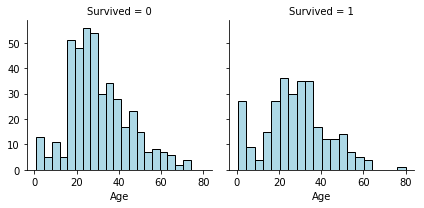

In [15]:
g = sns.FacetGrid(titanic, col = 'Survived')
g.map(plt.hist, 'Age', bins = 20, color = 'lightblue', edgecolor = 'black')

### 2 Correlating numerical and ordinal features, Age, Pclass & Survived

We can combine multiple features for identifying correlations using a single plot. This can be done with numerical and categorical features which have numeric values. 

#### 2.1 Observations

1). Pclass = 3 had most passengers, however most did not survive. Confirms our classifyint assumption #2. 

2). Infant passengers in Pclass = 2 and Pclass = 3 mostly survived. Further qualifies our classifying assumption #2. 

3). Most passengers in Pclass = 1 survived. Confirmed our classifying assumption #3. 

4). Pclass varies in terms of Age distribution of passengers. 

#### 2.2 Decision

1). Consider Pclass for model training. 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


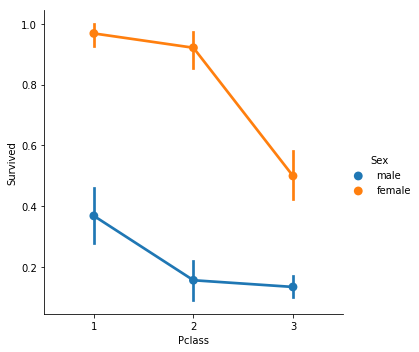

In [16]:
sns.factorplot('Pclass', 'Survived', hue = 'Sex', data = titanic)

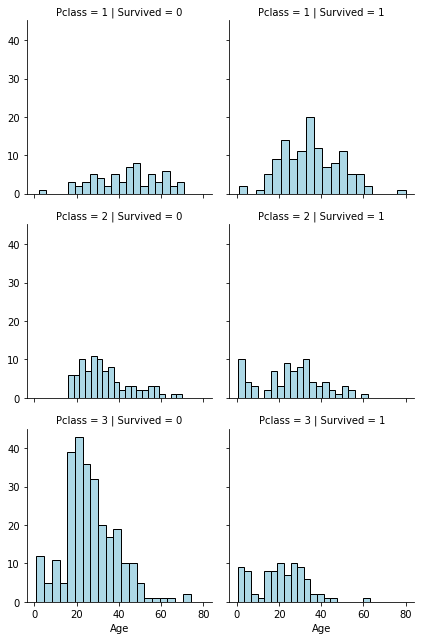

In [17]:
#grid = sns.FacetGrid(titanic, col = 'Pclass', hue = 'Survived')
grid = sns.FacetGrid(titanic, col = 'Survived', row = 'Pclass')
grid.map(plt.hist, 'Age', bins = 20, color = 'lightblue', edgecolor = 'black')

### 3. Correlating categorical features, Sex, Embarked  & Survived

Now we can correlate categorical features with our solution goal.

#### 3.1 Observations

1). Female passengers had much better suvival rate than males. Confirm classifying #1. 

2). Exception in Embarked = C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in ture Pclass and Survived, not necessarily direct correlation between Embarked and Survived. 

3). Males had better survival rate in Pclass = 3 when compared with Pclass = 2 for C and Q ports. Completing #2. 

4). Ports of embarkation have varying survival rates for Pclass = 3 and among male passengers. Correlating #1. 

#### 3.2 Decisions

1). Add Sex feature to model training. 

2). Complete and add Embarked feature to model training. 

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


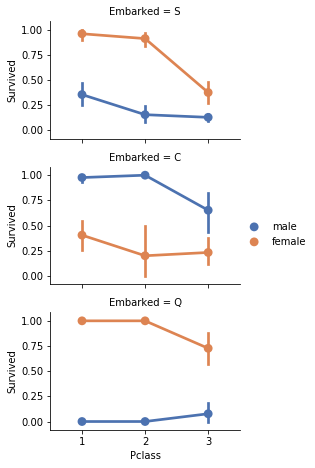

In [18]:
grid = sns.FacetGrid(titanic, row = 'Embarked', size = 2.2, aspect = 1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette = 'deep')
grid.add_legend()

### 4. Correlating categorical and numerical features, Fare, Embarked, Sex & Survived

We may also want to correlate categorical features (with non-numeric values) and numeric features. We can consider correlating Embarked (Categorical non-numeric), Sex(Categorical non-numeric), Fare(Numeric continuous), with Survived(Categorical numeric).

#### 4.1 Observations

1). Higher fare paying passengers had better survival. Confirms our assumption for creating #4 for fare ranges.

2). Port of embarkation correlations with survival rates. Confirms correlating #1 and completing #2. 

#### 4.2 Decisions

1). Consider banding Fare feature.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


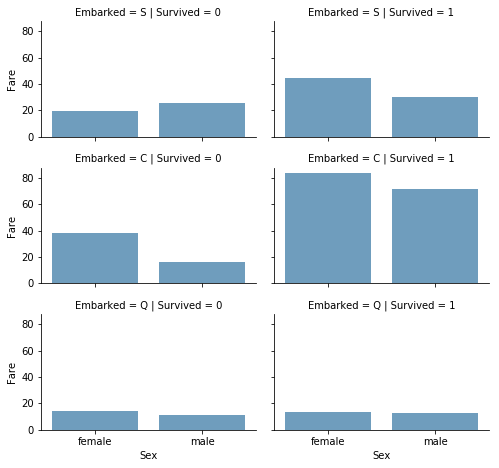

In [19]:
grid = sns.FacetGrid(titanic, col = 'Survived', row = 'Embarked', height = 2.2, aspect = 1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha = 0.7, ci = None )

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


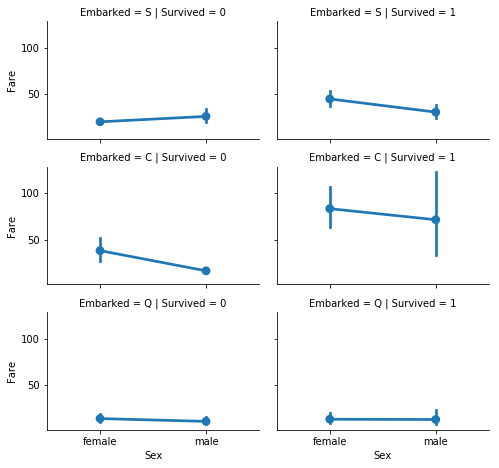

In [20]:
grid = sns.FacetGrid(titanic, col = 'Survived', row = 'Embarked', size = 2.2, aspect = 1.6)
grid.map(sns.pointplot, 'Sex', 'Fare' )

### 5. Dropping features, Ticket, Cabin, PassegerId

This is a good starting goal to execute. By dropping features we are dealing with fewer data points. Speeds up our notebook and eases the analysis.

Based on our assumptions and decisions we want to drop the Cabin and Ticket features.

Note that where applicable we perform operations on both training and testing datasets together to stay consistent.

In [21]:
print('Before:', titanic.shape, test.shape, combine[0].shape, combine[1].shape)

titanic = titanic.drop(['Ticket', 'Cabin', 'PassengerId'], axis = 1)
test = test.drop(['Ticket', 'Cabin', 'PassengerId'], axis = 1)

print('After:', titanic.shape, test.shape, combine[0].shape, combine[1].shape)

Before: (891, 12) (418, 11) (891, 12) (418, 11)
After: (891, 9) (418, 8) (891, 12) (418, 11)


### 6. Creating new feature (Name --> Title), and drop overlapped features

We want to analyze if Name feature can be engineered to extract titles and test correlation between titles and survival, before dropping Name and PassengerId features. 

In the following code we extract Title feature using regular expressions. The RegEx pattern(\w+\.)matches the first word which ends with a doc character within Name feature. The expand = False flag returns a DataFrame. 

We decide to retain the new Title feature for model training. 

In [0]:
titanic['Title'] = titanic['Name'].str.extract(' ([A-Za-z]+)\.', expand = False)
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand = False)

In [23]:
titanic['Title'] .value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Ms            1
Mme           1
Capt          1
Countess      1
Jonkheer      1
Don           1
Lady          1
Sir           1
Name: Title, dtype: int64

We can replace many titles with a more common name or classify them as Rare. 

In [24]:
# replace titles for titanic (training) dataset
titanic['Title'] = titanic['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don','Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic['Title'] = titanic['Title'].replace('Mlle', 'Miss')
titanic['Title'] = titanic['Title'].replace('Ms', 'Miss')
titanic['Title'] = titanic['Title'].replace('Mme', 'Mrs')
 
# replace titles for test dataset
test['Title'] = test['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don','Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test['Title'] = test['Title'].replace('Mlle', 'Miss')
test['Title'] = test['Title'].replace('Ms', 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')
 
print(titanic['Title'] .value_counts())
print("-" * 25)
print(titanic[['Title', 'Survived']].groupby(['Title'], as_index = False).mean())

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64
-------------------------
    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


We can convert the categorical titles to ordinal.

In [0]:
#title_mapping = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5}

# map titles for titanic (training) dataset 
#titanic['Title'] = titanic['Title'].map(title_mapping)
#titanic['Title'] = titanic['Title'].fillna(0)
 
# map titles for test dataset 
#test['Title'] = test['Title'].map(title_mapping)
#test['Title'] = test['Title'].fillna(0)

#titanic.head()

Now we can safely drop the Name feature from titanic and test datasets. 

In [26]:
# drop 'Name', 'PassengerId' features for titanic (training) dataset 
titanic = titanic.drop(['Name'], axis = 1)
 
# drop 'Name', 'PassengerId' features for test dataset 
test = test.drop(['Name'], axis = 1)
titanic.shape, test.shape

((891, 9), (418, 8))

In [27]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


### 7. Creating new feature ( SibSp + Parch--> FamilySize), and drop overlapped features

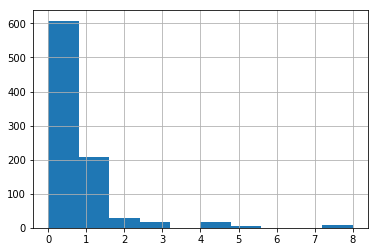

In [28]:
titanic['SibSp'].hist()

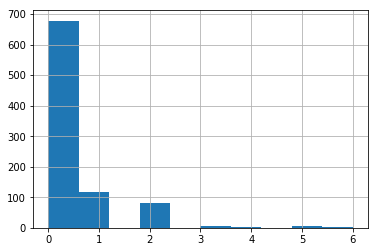

In [29]:
titanic['Parch'].hist()

In [0]:
# combine the variables 'SibSp' and 'Parch' for titanic (training) dataset
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch']

# combine the variables 'SibSp' and 'Parch' for test dataset
test['FamilySize'] = test['SibSp'] + test['Parch']

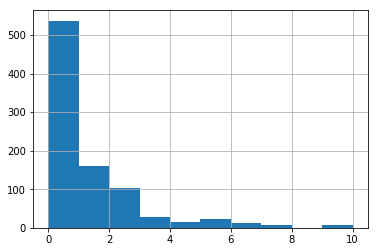

In [31]:
titanic['FamilySize'].hist()

In [32]:
# remove the variables not of interest
# drop 'SibSp', 'Parch' features for titanic (training) dataset 
titanic = titanic.drop(['SibSp', 'Parch'], axis = 1)
 
# drop 'SibSp', 'Parch' features for test dataset 
test = test.drop(['SibSp', 'Parch'], axis = 1)

titanic.shape, test.shape

((891, 8), (418, 7))

In [33]:
titanic.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,0,3,male,22.0,7.2500,S,Mr,1
1,1,1,female,38.0,71.2833,C,Mrs,1
2,1,3,female,26.0,7.9250,S,Miss,0
3,1,1,female,35.0,53.1000,S,Mrs,1
4,0,3,male,35.0,8.0500,S,Mr,0


## Part 6: Exploration of the data to replace the missing values for Features: Age, Embarked, Fare

In [34]:
print(titanic.isnull().sum())
print("-" * 20)
print(test.isnull().sum())

Survived        0
Pclass          0
Sex             0
Age           177
Fare            0
Embarked        2
Title           0
FamilySize      0
dtype: int64
--------------------
Pclass         0
Sex            0
Age           86
Fare           1
Embarked       0
Title          0
FamilySize     0
dtype: int64


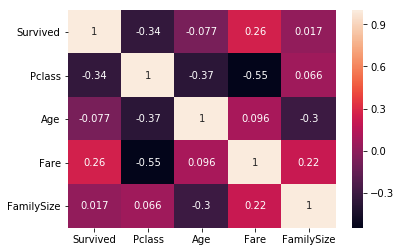

In [35]:
# check the relationship between the regressors
sns.heatmap(titanic.corr(), annot = True)

From the correlation plot, age has a quite strong linear relationship (-0.37) with Pclass, thus, we can consider replacing the missing values in age according to the Pclass. 

And also, Pclass has a quite strong linear relationship (-0.55) relationship with Fare. I will replace the  missing values in Facre based on their Pclass. 

#### 1. Replace missing values for Age



In [36]:
titanic.groupby('Pclass')['Age'].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [0]:
def age_approx(cols):
    age, pclass = cols
    if pd.isnull(age):
        if pclass == 1:
            return 38
        elif pclass == 2:
            return 30
        else:
            return 25
    else:
        return age

In [0]:
titanic['Age'] = titanic[['Age', 'Pclass']].apply(age_approx, axis = 1)
test['Age'] = test[['Age', 'Pclass']].apply(age_approx, axis = 1)

In [39]:
print(titanic.isnull().sum())
print("-" * 20)
print(test.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age           0
Fare          0
Embarked      2
Title         0
FamilySize    0
dtype: int64
--------------------
Pclass        0
Sex           0
Age           0
Fare          1
Embarked      0
Title         0
FamilySize    0
dtype: int64


Now, there is no missing value for variable 'Age', and two missing values for 'Embarked'. I will replace the 2 missing values with mode.

There is one missing value for Fare in test dataset. I will replace with it with mean.

#### 2. Replace missing values for Fare

In [40]:
titanic.groupby('Pclass')['Fare'].mean()

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

In [0]:
def fare_aprox(values):
    pclass, fare = values
    if pd.isnull(fare):
        if pclass == 1:
            return 85
        elif pclass == 2:
            return 21
        else:
            return 14
    else:
        return fare

In [0]:
titanic['Fare'] = titanic[['Pclass', 'Fare']].apply(fare_aprox, axis = 1)
test['Fare'] = test[['Pclass', 'Fare']].apply(fare_aprox, axis = 1)

#### 3. Replace missing values for Embarked

In [43]:
print(titanic["Embarked"].value_counts()) 
titanic["Embarked"] = titanic["Embarked"].fillna("S")
test["Embarked"] = test["Embarked"].fillna("S")

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [44]:
print(titanic.isnull().sum())
print("-" * 20)
print(test.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age           0
Fare          0
Embarked      0
Title         0
FamilySize    0
dtype: int64
--------------------
Pclass        0
Sex           0
Age           0
Fare          0
Embarked      0
Title         0
FamilySize    0
dtype: int64


Now, the data has been cleared, and there is no missing value. 

## Part 8: Convert string variable into numberical & Create dummy variables for categorical variables

#### 1. Convert String variable Sex into numberical

In [0]:
titanic['Sex'] = titanic['Sex'].map({'female': 1, 'male': 0}).astype = int()
test['Sex'] = test['Sex'].map({'female': 1, 'male': 0}).astype = int()

#### 2. Create dummy variables for categorical variable Embarked, & Title

In [48]:
Embarked_dummies = pd.get_dummies(titanic['Embarked'], prefix = 'Embarked') # drop_first = True,
Embarked_dummies.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [50]:
Title_dummies = pd.get_dummies(titanic['Title'], prefix = 'Title') # drop_first = True
Title_dummies.head()

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,0,1,0,0
1,0,0,0,1,0
2,0,1,0,0,0
3,0,0,0,1,0
4,0,0,1,0,0


In [0]:
titanic = titanic.drop(["Embarked", "Title"], axis = 1)

In [0]:
titanic = pd.concat([titanic,Embarked_dummies, Title_dummies], axis = 1)

In [0]:
# create dummy variables and concat for test dataset , drop_first = True
Embarked_dummies = pd.get_dummies(test['Embarked'], prefix = 'Embarked')
Title_dummies = pd.get_dummies(test['Title'], prefix = 'Title')
test = test.drop(['Title', 'Embarked'], axis = 1)
test = pd.concat([test, Embarked_dummies, Title_dummies], axis = 1)

In [54]:
titanic.head()

,Survived,Pclass,Sex,Age,Fare,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,3,0,22.0,7.2500,1,0,0,1,0,0,1,0,0
1,1,1,0,38.0,71.2833,1,1,0,0,0,0,0,1,0
2,1,3,0,26.0,7.9250,0,0,0,1,0,1,0,0,0
3,1,1,0,35.0,53.1000,1,0,0,1,0,0,0,1,0
4,0,3,0,35.0,8.0500,0,0,0,1,0,0,1,0,0


## Part 9: Check the sample size

There are 14 variables, and the sample size should be >= 50 * 14 = 700. And our sample size is 889, which is good.

In [55]:
len(titanic.columns.values)

14

In [56]:
len(titanic)

891

## Part 10: Model fittings (try different models for practice)

### Model 1. Multiple Linear Regression

*Get* the probabilities of survival for each passanger

In [0]:
#from sklearn.linear_model import LinearRegression
columns = titanic.columns.values
predictors = columns[1:]

In [58]:
predictors

array(['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Rare'], dtype=object)

In [0]:
mlg = LinearRegression()

# generate cross validaion folds for the titanic dataset. It return the row indices corresponding to train and test.
# We set random_state to ensure we get the same splits every time we run the model

kf = KFold(n_splits = 3)
predictions = []
for train, val in kf.split(titanic[predictors], titanic["Survived"]):
  train_predictors = titanic[predictors].iloc[train, :]
  train_target = titanic["Survived"].iloc[train]
  mlg.fit(train_predictors, train_target)
  test_predictions = mlg.predict(titanic[predictors].iloc[val, :])
  predictions.append(test_predictions)
#print(len(test_predictions))

In [0]:
# convert the probabilities into 0 or 1
import numpy as np
predictions = np.concatenate(predictions, axis = 0)
predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0

In [61]:
accuracy = sum(predictions[predictions == titanic["Survived"]])/len(predictions)
print(accuracy)

0.28170594837261503


### Model 2. Logistic Regression (validation acc: 0.82)

#### 2.1. Train the model

In [62]:
# Method 1: with cross_val
kf = KFold(n_splits = 3)
lg = LogisticRegression(random_state = 1)

lr_predictions = []
scores = cross_val_score(lg, titanic[predictors], titanic["Survived"], cv = 3)

print(scores)

[0.7979798  0.82828283 0.83164983]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [68]:
lr_test_predictions = []
scores = []
for train, val in kf.split(titanic[predictors], titanic["Survived"]):
  train_predictors = titanic[predictors].iloc[train, :]
  train_target = titanic["Survived"].iloc[train]
  val_predictors = titanic[predictors].iloc[val, :]
  val_target = titanic["Survived"].iloc[val]
  score = lg.fit(train_predictors, train_target).score(val_predictors, val_target)
  scores.append(score)
  pred = lg.predict(test)
print(np.mean(scores))

0.8226711560044894


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [84]:
# Method 2: with iteration
lr_test_predictions = []
scores = []
for train, val in kf.split(titanic[predictors], titanic["Survived"]):
  train_predictors = titanic[predictors].iloc[train, :]
  train_target = titanic["Survived"].iloc[train]
  
  val_predictors = titanic[predictors].iloc[val, :]
  val_target = titanic["Survived"].iloc[val]
  
  
  score = lg.fit(train_predictors, train_target).score(val_predictors, val_target)
  pred = lg.predict(test)
  
  scores.append(score)
  lr_test_predictions.append(pred)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### 2.2 Get the predicted values for the test data from each of the three models, and determine the majority vote as the final label

In [112]:
predictions = np.column_stack((lr_test_predictions[0], lr_test_predictions[1], lr_test_predictions[2]))
print(len(predictions))

418


In [113]:
# print the first 5 predictions from each of the 3 models
predictions[:5]

array([[0, 0, 0],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 1]])

In [109]:
# choose the majority vote as the final vote
labels = np.zeros(len(predictions))
for i in range(50):
  c = Counter(res[i])
  label, count = c.most_common()[0]
  labels[i] = label
print(labels)

[0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

#### 2.3  prepare data for Kaggle submission

In [124]:
get_test_id = pd.read_csv('test.csv')
PassengerId = get_test_id.PassengerId
Survived = labels
titanic_submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": Survived}, dtype = int)

print(titanic_submission[:10])
titanic_submission.to_csv("/content/titanic_submission.csv")

   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0


### Model 3. Random Forest (validation acc: 0.84)

In [125]:
rfc = RandomForestClassifier(random_state = 1, n_estimators = 10, min_samples_split = 2, min_samples_leaf = 1)

kf = KFold(n_splits = 3, random_state = 1)
scores = cross_val_score(rfc, titanic[predictors], titanic["Survived"], cv = kf, scoring = "accuracy")
print("Accuracy for each of 3 folds:", scores)
print("Mean accuracy: {:.4f}".format(scores.mean()))


Accuracy for each of 3 folds: [0.75757576 0.78451178 0.8013468 ]
Mean accuracy: 0.7811


#### 3.1 Fine tune with different number of trees

In [0]:
accurs = []
for n in range(10, 100):
      rfc = RandomForestClassifier(random_state = 1, n_estimators = n, min_samples_split = 2, min_samples_leaf = 4)
      kf = KFold(n_splits = 3, random_state = 1)
      scores = cross_val_score(rfc, titanic[predictors], titanic["Survived"], cv = kf)
      accurs.append(scores.mean())

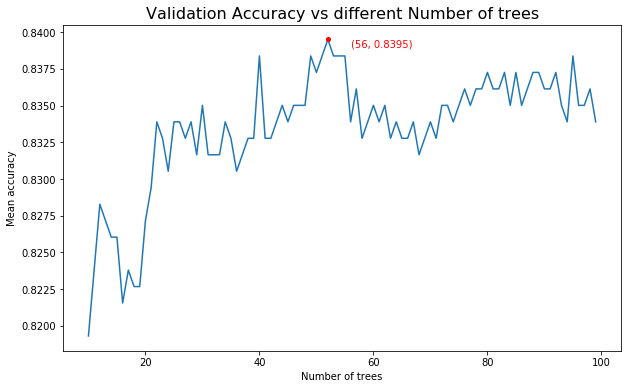

In [179]:
plt.figure(figsize = (10, 6))
plt.plot(range(10, 100), accurs)
plt.title("Validation Accuracy vs different Number of trees", size = 16, color = "black")
#plt.axhline(y = max(accurs), ls ='--', color = 'red')
plt.plot([52], [0.8395061728395062], marker='o', markersize=4, color="red")
plt.text(56, 0.839, '(56, 0.8395)', color = "red", size = 10)
plt.xlabel("Number of trees")
plt.ylabel("Mean accuracy")
plt.show()

In [171]:
# get the index of the best accuracy
print("Best, acc:", max(accurs))
print(accurs.index(max(accurs)))

Best, acc: 0.8395061728395062
42


In [168]:
# get the value of the best number of trees
range(10, 100)[42]

52

## Other notes: assumptions for logistic regression


We arrive at following assumptions based on data analysis done so far. We may validate these assumptions further before taking appropriate actions. 

1). For a binary Logistic Regression, the target variable should be binary. (The values for the target variable 'Survived' are 1 (survived) and 0 (not survived). This assumption is satisfied.)

2). Only the meaningful variables should be included. At the next step, the unrelated variables will be removed. 

3). The independent variables should be independent of each other. That is, this is no multicollinearity problem. 

4). The independent variables should be linearly related to the log odds. 

5). The Logistic Regression requires large sample size. (50 records for each predictor, for 6 variables, the sample size should be >= 300.)